In [19]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np

# Utilities

## Points and Distances

Euclidean Distance between two points

In [20]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

The nearest link between two point sets

In [21]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP         

## Graphs

In [22]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [23]:
def plotGraph(P, E, col='b', grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()

The random generation may result in a graph consisting of multiple not connected subgraphs.
Split a graph into not connected subgraphs, if any.

In [24]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E       

In [25]:
def generateGraph(n, x0, y0, r):
    P, E = generateRandomGraph(n, x0, y0, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

## Lists and Paths

In [26]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [27]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [28]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [29]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

## Generate Customer Locations

In [30]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [31]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [32]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Generate Warehouse Locations

In [33]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

In [34]:
def generateWarehouseLocations(M, seed=None):
    if seed is not None:
        random.seed(seed)
    V, _ = M
    W = random.sample(V, k=len(V)//10)
    return W

## Plot Map with Delivery Route

In [35]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        minX = min([p[0] for p in V])
        plt.text(minX, 0, text)
    if grid:
        plt.grid()
    plt.show()

## Generate Data

In [36]:
def generateData(seed=None, nodes=100, customers=150, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    V, E = generateGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C

In [37]:
D1 = generateData(1234)
D2 = generateData(1234)
D1 == D2

True

# Generating Data

This section demonstrates how you can generate the test data for the problem.

## Real Sample Data

This section shows sample data as you you may get them for your required simulation. 

Generated map with 40 nodes and 20 customer locations


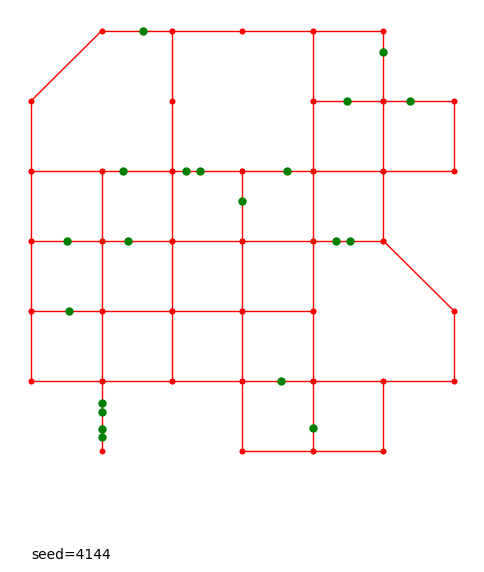

In [40]:
data = generateData(4144, nodes= 40, customers= 20 ,plot=True, log=True)

Save sample data as pickle file:

In [41]:
import pickle
with open('data.pickled', 'wb') as f:
    pickle.dump(data, f)